# Double descent on a simple regression
Double descent is a phenomenon beyond bias-variance tradeoff, primarily discovered in deep learning: more parameters leads to overfitting and decreasing generalization power, up to a point where overparametrization wins and generalization error starts to improve again.

This phenomenon was mostly shown to happen empirically in deep convolution networks for image processing tasks. This notebook aims to show hints of the double descent in a simpler regression context with small feed-forward networks..

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D  # unused import, required by projection='3d'
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set()

### Neural network class

In [2]:
class Model(nn.Module):
    """Basic customizable network structure
    """
    def __init__(self,
                 input_size=1,
                 output_size=1,
                 hidden_size=2,
                 n_layers=1,
                 activation='relu',
                ):
        super(Model, self).__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        # number of hidden layers
        self.n_layers = n_layers
        
        size  = [self.input_size] + [hidden_size,] * (self.n_layers)
        self.layers = [nn.Linear(size[i-1], size[i]) for i in range(1, self.n_layers+1)]
        self.layers.append(nn.Linear(hidden_size, self.output_size))
        
        self.layers = nn.ModuleList(self.layers)
        
        if activation.lower() == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation.lower() == 'relu':
            self.activation = nn.ReLU()
        elif activation.lower() == 'leakyrelu':
            self.activation = nn.LeakyReLU(negative_slope=0.1)
        elif activation.lower() == 'tanh':
            self.activation = nn.Tanh()
        else:
            raise Exception('{} not an available activation'.format(activation))
        
    def forward(self, x):
        for i in range(self.n_layers):
            x = self.activation(self.layers[i](x))
        x = self.layers[-1](x)
        return x

In [3]:
class TrainManager():
    """Helper class to centralize various parameters/optimizer/criterion choices, 
    train and test routines.
    """
    def __init__(self,
                 model,
                 dataset=[],
                 tol=0.1,
                 tol_type='absolute',
                 num_epochs_max=int(1e3),
                 batch_size=10,
                 lr=0.01,
                 criterion=nn.MSELoss(),
                 optimizer_name='SGD',
                 verbose=False,
                ):
        
        self._model = model
        self.dataset = dataset
        self.tol = tol
        self.tol_type = tol_type
        self.num_epochs_max = num_epochs_max
        self.batch_size = batch_size
        self.lr = lr
        self.criterion = criterion
        self.optimizer_name = optimizer_name
        self.verbose = verbose
        self.num_epochs = 0
        self.train_error = torch.tensor([0.0])
        self.test_error = torch.tensor([0.0])
        
    @property
    def model(self):
        return self._model
    @model.setter
    def model(self, new_model):
        """Load new model and relink the optimizer to 
        the parameters of the current model.
        """
        self._model = new_model
        self.optimizer_name = self._optimizer_name
        
    @property
    def optimizer_name(self):
        return self._optimizer_name
    @optimizer_name.setter
    def optimizer_name(self, new_optimizer_name):
        """Set optimizer from optimizer_name and
        most importantly, link it to the parameters 
        of the current model loaded in the train manager.
        """
        self._optimizer_name = new_optimizer_name
        if new_optimizer_name.lower() == 'sgd':
            self.optimizer = torch.optim.SGD(self._model.parameters(), lr=self.lr)
        elif new_optimizer_name.lower() == 'adam':
            self.optimizer = torch.optim.Adam(self._model.parameters(), lr=self.lr)
        elif new_optimizer_name.lower() == 'rmsprop':
            self.optimizer = torch.optim.RMSprop(self._model.parameters(), lr=self.lr)
        else:
            raise Exception('Unknown optimizer {}'.format(optimizer))
            
    def train(self):
        """Train model and display learning_curve.
        """
        train_error = []
        train_loader = DataLoader(self.dataset, self.batch_size, shuffle=True)
        self.model.train()
        keep_training = True
        epoch = 0
        while keep_training:
            epoch += 1
            epoch_average_loss = 0.0
            for (X_batch, y_real) in train_loader:
                y_pre = self.model.forward(X_batch).view(-1)
                loss = self.criterion(y_pre, y_real)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                epoch_average_loss += loss.item() * self.batch_size / len(self.dataset)
            # stop training after loss tolerance is reached
            if epoch != 1:
                if self.tol_type == 'increment' and np.abs(train_error[-1]-epoch_average_loss) < self.tol\
                or self.tol_type == 'absolute' and epoch_average_loss < self.tol\
                or epoch >= self.num_epochs_max:
                    keep_training = False
                
            train_error.append(epoch_average_loss)
            if self.verbose:
                print('Epoch {}, Loss: {:.4f}'.format(epoch, epoch_average_loss))
            
        if self.verbose:
            # plot the training error wrt. the number of epochs: 
            plt.plot(train_error)
            plt.xlabel("num_epochs")
            plt.ylabel("Train error")
            plt.title("Visualization of convergence")
        self.num_epochs = epoch
        self.train_error = train_error
    
    def test(self, X_val, y_real):
        """Evaluate model on X_val.
        """
        # predict labels for validation set
        self.model.eval() # set the model to test mode
        with torch.no_grad():
            y_pre = self.model.forward(X_val).view(-1)
        
        self.test_error = self.criterion(y_pre, y_real).item()

### Generate data : sinusoid mountains

In [83]:
N = int(1e3)
noise_std = 0.1

def f(x1, x2):
    return np.sin(2*np.pi/5*x1)*np.sin(3*np.pi/5*x2)

x1 = 2*(2*np.random.rand(N)-1)
x2 = 3*(2*np.random.rand(N)-1)
X = np.stack([x1, x2], axis=1)
y = f(x1, x2) + noise_std*np.random.randn(N)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
training_set = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
X_test, y_test = torch.FloatTensor(X_test), torch.FloatTensor(y_test)

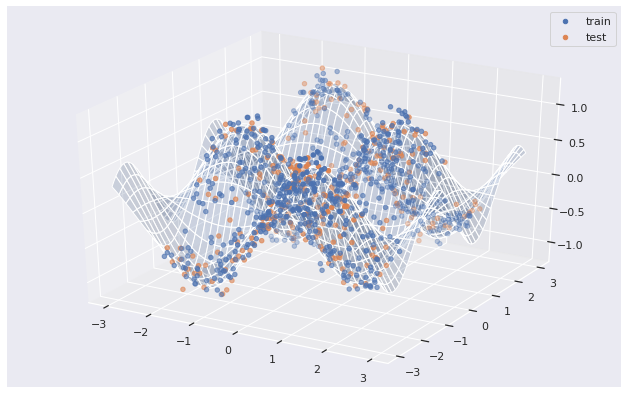

In [84]:
fig = plt.figure(figsize=(11, 7))

x1_plot = x2_plot = np.arange(-3.0, 3.0, 0.05)
X1_plot, X2_plot = np.meshgrid(x1_plot, x2_plot)
y_plot = np.array(f(np.ravel(X1_plot), np.ravel(X2_plot)))
Y_plot = y_plot.reshape(X1_plot.shape)

ax = fig.gca(projection='3d')
ax.scatter(X_train[:, 0], X_train[:, 1], y_train, label='train')
ax.scatter(X_test[:, 0], X_test[:, 1], y_test, label='test')
ax.plot_surface(X1_plot, X2_plot, Y_plot, alpha=0.2)
ax.legend()
plt.show()

### Setup training

In [85]:
# choose the hyperparameters for training
tol = 5e-4
tol_type = 'absolute'
num_epochs_max = int(5e2)
batch_size = 50

# training criterion. 
criterion = nn.MSELoss()

# optimizer
optimizer_name = 'Adam'

# learning rate
lr = 0.01

# create the model: 
model = Model(input_size=2,
              output_size=1,
              hidden_size=12,
              n_layers=2,
             )

mgr = TrainManager(model,
                   dataset=training_set,
                   tol=tol,
                   tol_type=tol_type,
                   num_epochs_max=num_epochs_max,
                   batch_size=batch_size,
                   lr=lr,
                   criterion=criterion,
                   optimizer_name=optimizer_name,
                   verbose=False,
                  )

### Test with increasing number of neurons or layers

In [87]:
# hidden_sizes = list(range(8, 512, 16))
n_layerss = list(range(1, 32))
test_errors_avg = []
test_errors_std = []
num_epochs = []
postfix = {
    'test error': 0.0,
    'num epochs': 0,
}
n_sim = 5
# with tqdm(total=len(hidden_sizes), postfix=postfix) as pbar:
with tqdm(total=len(n_layerss), postfix=postfix) as pbar:
#     for hidden_size in hidden_sizes:
    for n_layers in n_layerss:
        test_error_sim = np.empty(n_sim)
        num_epochs_sim = np.empty(n_sim)
        for i in range(n_sim):
#             model = Model(input_size=2, output_size=1, n_layers=2, hidden_size=hidden_size)
            model = Model(input_size=2, output_size=1, n_layers=n_layers, hidden_size=4)
            mgr.model = model
            mgr.train()
            mgr.test(X_test, y_test)
            test_error_sim[i] = mgr.test_error
            num_epochs_sim[i] = mgr.num_epochs
        test_errors_avg.append(test_error_sim.mean())
        test_errors_std.append(test_error_sim.std())
        num_epochs.append(int(np.ceil(num_epochs_sim.mean())))
        
        # log
        postfix['test error'] = test_error_sim.mean()
        postfix['num epochs'] = num_epochs[-1]
        pbar.set_postfix(postfix)
        pbar.update()

100%|██████████| 31/31 [1:26:20<00:00, 167.11s/it, test error=0.347, num epochs=500]


### No double descent in this low-dimensional problem

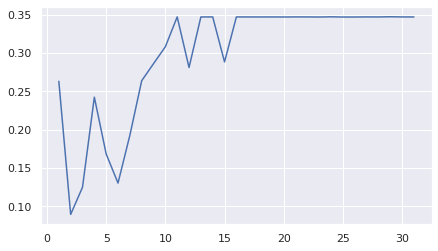

In [89]:
fig, ax = plt.subplots(figsize=(7, 4), nrows=1, ncols=1)
# ax.plot(hidden_sizes, test_errors_avg)
ax.plot(n_layerss, test_errors_avg)

### Generate data : sinusoid mountains in higher dimensions

In [39]:
N = int(1e3)
d = 64
noise_std = 0.1

def f(x):
    d = x.shape[1]
    freqs = np.random.randint(1, 100, d)
    return np.prod(np.sin(freqs*np.pi/50*x))

X = (2*np.random.rand(N, d)-1)
y = f(X) + noise_std*np.random.randn(N)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
training_set = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
X_test, y_test = torch.FloatTensor(X_test), torch.FloatTensor(y_test)

In [80]:
# choose the hyperparameters for training
tol = 1e-4
tol_type = 'absolute'
num_epochs_max = int(5e2)
batch_size = 100

# training criterion. 
criterion = nn.MSELoss()

# optimizer
optimizer_name = 'Adam'

# learning rate
lr = 0.01

# create the model: 
model = Model(input_size=d,
              output_size=1,
              hidden_size=12,
              n_layers=3,
             )

mgr = TrainManager(model,
                   dataset=training_set,
                   tol=tol,
                   tol_type=tol_type,
                   num_epochs_max=num_epochs_max,
                   batch_size=batch_size,
                   lr=lr,
                   criterion=criterion,
                   optimizer_name=optimizer_name,
                   verbose=False,
                  )

In [81]:
# hidden_sizes = list(range(8, 512, 16))
n_layerss = list(range(1, 32))
test_errors_avg = []
test_errors_std = []
num_epochs = []
postfix = {
    'test error': 0.0,
    'num epochs': 0,
}
n_sim = 5
# with tqdm(total=len(hidden_sizes), postfix=postfix) as pbar:
with tqdm(total=len(n_layerss), postfix=postfix) as pbar:
#     for hidden_size in hidden_sizes:
    for n_layers in n_layerss:
        test_error_sim = np.empty(n_sim)
        num_epochs_sim = np.empty(n_sim)
        for i in range(n_sim):
#             model = Model(input_size=d, output_size=1, n_layers=2, hidden_size=hidden_size)
            model = Model(input_size=d, output_size=1, n_layers=n_layers, hidden_size=4)
            mgr.model = model
            mgr.train()
            mgr.test(X_test, y_test)
            test_error_sim[i] = mgr.test_error
            num_epochs_sim[i] = mgr.num_epochs
        test_errors_avg.append(test_error_sim.mean())
        test_errors_std.append(test_error_sim.std())
        num_epochs.append(int(np.ceil(num_epochs_sim.mean())))
        
        # log
        postfix['test error'] = test_error_sim.mean()
        postfix['num epochs'] = num_epochs[-1]
        pbar.set_postfix(postfix)
        pbar.update()

100%|██████████| 31/31 [35:50<00:00, 69.38s/it, test error=0.00983, num epochs=500] 


### Very noisy, but potential double descent

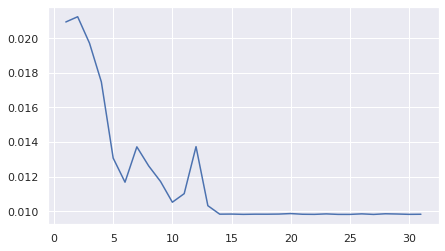

In [82]:
fig, ax = plt.subplots(figsize=(7, 4), nrows=1, ncols=1)
# ax.plot(hidden_sizes, test_errors_avg)
ax.plot(n_layerss, test_errors_avg)